<a href="https://colab.research.google.com/github/bk-12346/CV/blob/main/Bag_of_visual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#accessing the datset through Google Drive
!gdown https://drive.google.com/drive/u/1/folders/1WtgN1akdxNsAIBQrO38vqKvzQh0mQ-OL
!unzip /content/Objects_Dataset_Images-20230312T154318Z-001.zip;



/usr/local/lib/python3.9/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/u/1/folders/1WtgN1akdxNsAIBQrO38vqKvzQh0mQ-OL
To: /content/1WtgN1akdxNsAIBQrO38vqKvzQh0mQ-OL
993kB [00:00, 49.1MB/s]
Archive:  /content/Objects_Dataset_Images-20230312T154318Z-001.zip
replace Objects_Dataset_Images/train/Soccer_Ball/image_0014.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Objects_Dataset_Images/test/motorbike/image_0030.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Objects_Dataset_Images/train/motorbike/image_0015.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Objects_Dataset_Images/train/motorbike/image_0012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Objects_Dataset_Images/train/motorbike/image_0012.jpg  
  inflatin

In [82]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
import math
from tqdm import tqdm
import pickle

# takes all images and convert them to grayscale. It also returns a dictionary that holds all images according to category. 
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for accordian in os.listdir(path):
            img = cv2.imread(path + "/" + accordian,0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder('Objects_Dataset_Images/train')  # take all images category by category 
test = load_images_from_folder("Objects_Dataset_Images/test") # take test images


In [62]:
#SIFT
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
           
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 

In [32]:
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(150, descriptor_list) 

In [65]:
  def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    

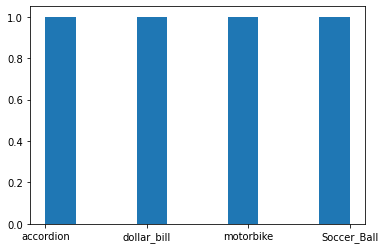

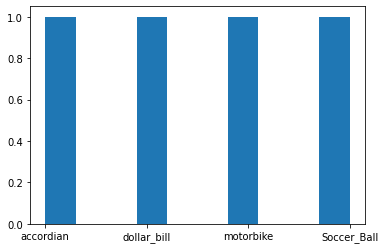

In [80]:
from matplotlib import pyplot as plt
# Creates histograms for train data    
bow_train = image_class(all_bovw_feature, visual_words) 
plt.hist(bow_train, bins=10)
plt.show()
# Creates histograms for test data
bow_test = image_class(test_bovw_feature, visual_words) 
plt.hist(bow_test, bins=10)
plt.show()

In [91]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for testing in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(testing, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(testing, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bow_train, bow_test) 



In [92]:
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies      
accuracy(results_bowl) 

Average accuracy: %75.0

Class based accuracies: 

accordian : %0.0
dollar_bill : %100.0
motorbike : %100.0
Soccer_Ball : %100.0
